# Vorbereitung

## Dependencies

In [6]:
import keras
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from keras import backend as k


## Datensätze

### Künstlichen Datensatz erzeugen

In [7]:
def target_variable(x):
    return (1/2)*x[0] - (1/4)*(x[1]**2) + (1/2)*abs(x[2])*math.sin(2*x[2]) + (1/2)*x[3]*x[4] + (1/8)*(x[4]**2)*x[5]

In [8]:
# Random Number Generator
rng = np.random.default_rng()

# Trainingsdatensatz
## Generate Training Data x1, x3, x4, x5, x6, x7
x1_train = rng.standard_normal(size=(100000,1))
x3_7_train = rng.standard_normal(size=(100000, 5))

## Variablen x2, x8 mit 50 % Korrelation
cov_matrix = [[1, 0.5], [0.5, 1]]
x2_x8_train = rng.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=100000)

# Zusammenfügen und Zielvariable berechnen
x_train = np.column_stack(
    (x1_train, x2_x8_train[:, 0], x3_7_train, x2_x8_train[:, 1]))
y_train = np.array(list(map(target_variable, x_train[:, 0:7])))


In [9]:
# Testdatensatz
## Generate Training Data x1, x3, x4, x5, x6, x7
x1_test = rng.standard_normal(size=(100000, 1))
x3_7_test = rng.standard_normal(size=(100000, 5))

## Variablen x2, x8 mit 50 % Korrelation
x2_x8_test = rng.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=100000)

# Zusammenfügen und Zielvariable berechnen
x_test = np.column_stack(
    (x1_test, x2_x8_test[:, 0], x3_7_test, x2_x8_test[:, 1]))
y_test = np.array(list(map(target_variable, x_test[:, 0:7])))

In [10]:
# Check, if x2 and x8 are correlated
np.cov(x_train[:,1],x_train[:,7])

array([[1.00090517, 0.49767046],
       [0.49767046, 0.99209379]])

### Realer Datensatz

In [11]:
# french motor third party liability dataset
mtpl_df = pd.read_csv("freMTPL2freq.csv")


In [12]:
mtpl_df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


# LocalGLMnet

## Model trainieren

In [13]:
input = keras.Input(shape=(8), dtype= "float32")  

In [14]:
attention = input

attention = keras.layers.Dense(units=20, activation="tanh")(attention)
attention = keras.layers.Dense(units=15, activation="tanh")(attention)
attention = keras.layers.Dense(units=10, activation="tanh")(attention)
attention = keras.layers.Dense(units=8, activation="linear", name="Attention")(attention)

2022-11-21 21:45:15.476866: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
response = keras.layers.Dot(axes=1)([input, attention])
response = keras.layers.Dense(units=1, activation="linear", name="Response")(response)

In [16]:
model = keras.Model(inputs=input, outputs=response)
model.compile(loss="mse", optimizer="nadam")

In [17]:
history = model.fit(x_train, y_train,
          batch_size=32, epochs=10)

2022-11-21 21:45:15.768676: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.1946
Epoch 2/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0519
Epoch 3/10
3125/3125 [==============================] - 3s 977us/step - loss: 0.0361
Epoch 4/10
3125/3125 [==============================] - 3s 979us/step - loss: 0.0259
Epoch 5/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0150
Epoch 6/10
3125/3125 [==============================] - 3s 962us/step - loss: 0.0077
Epoch 7/10
3125/3125 [==============================] - 3s 963us/step - loss: 0.0055
Epoch 8/10
3125/3125 [==============================] - 3s 982us/step - loss: 0.0047
Epoch 9/10
3125/3125 [==============================] - 3s 960us/step - loss: 0.0043
Epoch 10/10
3125/3125 [==============================] - 3s 998us/step - loss: 0.0042


In [18]:
print(history.history)

{'loss': [0.19459748268127441, 0.05190378427505493, 0.03613800182938576, 0.025921531021595, 0.01497930008918047, 0.007722204085439444, 0.0054918695241212845, 0.0046560862101614475, 0.004324491135776043, 0.004154767841100693]}


## Regression Attention

In [19]:
# Über die Methode get_weights() erhält man die Kantengewichte, sowie den Bias für jeder Schicht
# --> man erhält also eine Liste mit numpy Arrays die in der Länge der Anzahl der Ebenen * 2

for i in model.get_weights():
    print(i.shape, end= " | ")

(8, 20) | (20,) | (20, 15) | (15,) | (15, 10) | (10,) | (10, 8) | (8,) | (1, 1) | (1,) | 

In [20]:
# Neues Model ohne Response-Schicht --> auslesen der Attention Schicht
weights_model = keras.Model(
    inputs=model.input, 
    outputs=model.get_layer(name="Attention").output)

# Gewichte bestimmen
beta_x = weights_model.predict(x_test)

In [21]:
# Skalierung der Attention mithilfe der Gewichte der Response Schicht (!= der tatsächlichen Vorhersage (--> beta_x liefert 8 Outputwerte, Response nur 1 Output))
beta_x = beta_x * model.get_weights()[8]

# our architecture still requires a scaling coming from dense layer ’Response’ which 
# we add to have intercept beta_0 in our LocalGLMnet architecture 
# beta.x <- beta.x * as.numeric(get_weights(model)[[9]])

# Ggf. in die Skalierung letzten Bias mit aufnehmen?
# --> beta_x = beta_x * model.get_weights()[8] + model.get_weights()[9]


## Plots

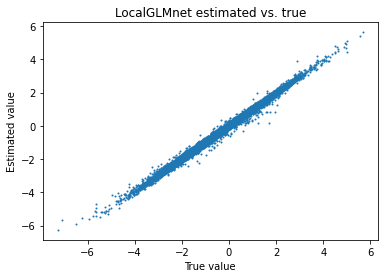

In [22]:
pred = model.predict(x_test)

plt.scatter(y_test, pred, s= 1)
plt.xlabel("True value")
plt.ylabel("Estimated value")
plt.title("LocalGLMnet estimated vs. true")
plt.show()

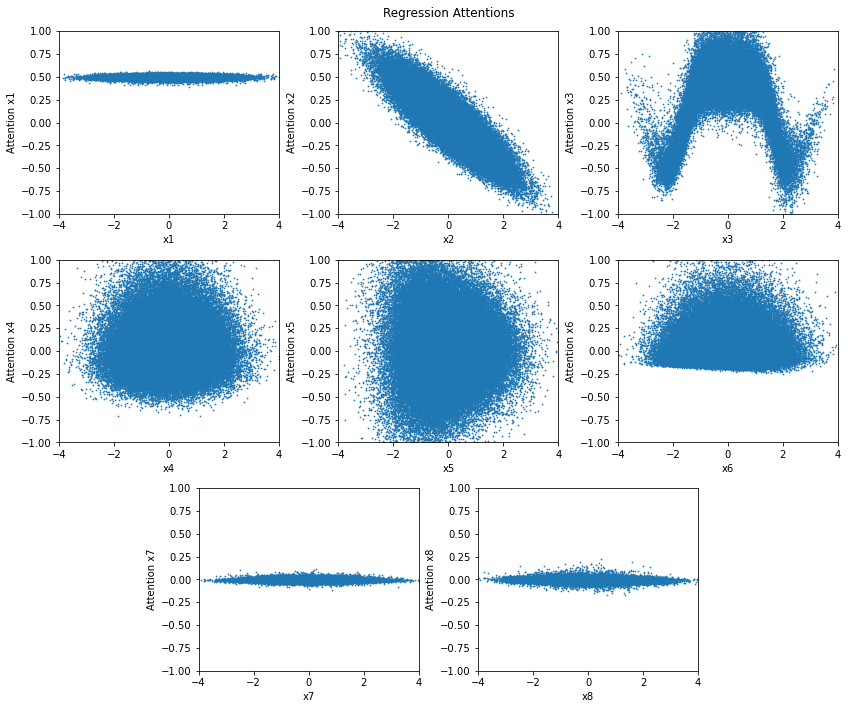

In [23]:
fig_attention = plt.figure(tight_layout=True, figsize=(15,10))

spec = GridSpec(ncols=8, nrows=3, figure=fig_attention)
ax1_att = fig_attention.add_subplot(spec[0, 1:3])
ax2_att = fig_attention.add_subplot(spec[0, 3:5])
ax3_att = fig_attention.add_subplot(spec[0, 5:7])
ax4_att = fig_attention.add_subplot(spec[1, 1:3])
ax5_att = fig_attention.add_subplot(spec[1, 3:5])
ax6_att = fig_attention.add_subplot(spec[1, 5:7])
ax7_att = fig_attention.add_subplot(spec[2, 2:4])
ax8_att = fig_attention.add_subplot(spec[2, 4:6])

axs = [ax1_att, ax2_att, ax3_att, ax4_att, ax5_att, ax6_att, ax7_att, ax8_att]

for i in range(len(axs)):
    axs[i].scatter(x_test[:, i],
                     beta_x[:, i], s=0.5)
    axs[i].set_xlim((-4, 4))
    axs[i].set_ylim((-1, 1))
    axs[i].set_xlabel('x'+str(i+1))
    axs[i].set_ylabel('Attention x'+str(i+1))

fig_attention.suptitle("Regression Attentions")
plt.show()


### Spline Fits

In [29]:
beta_1 = attention
beta_1 = keras.layers.Lambda(lambda x: x[:,1])
model_1 = keras.Model(inputs = input, outputs = beta_1)(beta_1)

grad = beta_1
grad = keras.layers.Lambda(lambda x: k.gradients(model_1.outputs, model_1.inputs))
model_grad = keras.Model(inputs = input, outputs = grad)

grad_beta = model_grad.predict(x=x_test)
 

ValueError: Output tensors of a Functional model must be the output of a TensorFlow `Layer` (thus holding past layer metadata). Found: <keras.layers.core.Lambda object at 0x7fd22fe871c0>